<a href="https://colab.research.google.com/github/yoyoyo-yo/DeepLearningMugenKnock/blob/master/Scripts_Generative/pytorch/DCGAN_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DCGAN, original dataset

In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install numpy matplotlib opencv-python torch torchvision torchsummary pandas easydict

## Import and Config

In [3]:
import torch
import torch.nn.functional as F
import torchvision
import numpy as np
from collections import OrderedDict
from easydict import EasyDict
import argparse
import os
import matplotlib.pyplot as plt
import pandas as pd
from torchsummary import summary
from pprint import pprint

import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/pytorch/')
from _main_base_generative import *

#---
# config
#---
cfg = EasyDict()

# class
cfg.CLASS_LABEL = ['akahara', 'madara'] # list, dict('label' : '[B, G, R]')
cfg.CLASS_NUM = len(cfg.CLASS_LABEL)

# model
cfg.INPUT_Z_DIM = 100
cfg.INPUT_MODE = None
cfg.INPUT_CMAP = None

cfg.OUTPUT_HEIGHT = 64
cfg.OUTPUT_WIDTH = 64
cfg.OUTPUT_CHANNEL = 3
cfg.OUTPUT_MODE = 'RGB'  # RGB, GRAY, EDGE, CLASS_LABEL
cfg.OUTPUT_CMAP = None

cfg.G_DIM = 32
cfg.D_DIM = 32

cfg.CHANNEL_AXIS = 1 # 1 ... [mb, c, h, w], 3 ... [mb, h, w, c]

cfg.GPU = True
cfg.DEVICE_TYPE = 'cuda' if cfg.GPU and torch.cuda.is_available() else 'cpu'
cfg.DEVICE = torch.device(cfg.DEVICE_TYPE)

# train
cfg.TRAIN = EasyDict()
cfg.TRAIN.DISPAY_ITERATION_INTERVAL = 50

cfg.PREFIX = 'DCGAN'
cfg.TRAIN.MODEL_G_SAVE_PATH = 'models/' + cfg.PREFIX + '_G_{}.pt'
cfg.TRAIN.MODEL_D_SAVE_PATH = 'models/' + cfg.PREFIX + '_D_{}.pt'
cfg.TRAIN.MODEL_SAVE_INTERVAL = 200
cfg.TRAIN.ITERATION = 10_000
cfg.TRAIN.MINIBATCH = 32
cfg.TRAIN.OPTIMIZER_G = torch.optim.Adam
cfg.TRAIN.LEARNING_PARAMS_G = {'lr' : 0.0002, 'betas' : (0.5, 0.9)}
cfg.TRAIN.OPTIMIZER_D = torch.optim.Adam
cfg.TRAIN.LEARNING_PARAMS_D = {'lr' : 0.0002, 'betas' : (0.5, 0.9)}
cfg.TRAIN.LOSS_FUNCTION = loss_fn = torch.nn.BCELoss()

cfg.TRAIN.DATA_PATH = '/content/drive/My Drive/Colab Notebooks/train/images/'
cfg.TRAIN.DATA_HORIZONTAL_FLIP = True # data augmentation : holizontal flip
cfg.TRAIN.DATA_VERTICAL_FLIP = True # data augmentation : vertical flip
cfg.TRAIN.DATA_ROTATION = 1 # data augmentation : rotation False, or integer

cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE = True
cfg.TRAIN.LEARNING_PROCESS_RESULT_INTERVAL = 500
cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH = 'result/' + cfg.PREFIX + '_result_{}.jpg'
cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH = 'result/' + cfg.PREFIX + '_loss.txt'

# test
cfg.TEST = EasyDict()
cfg.TEST.MODEL_G_PATH = cfg.TRAIN.MODEL_G_SAVE_PATH.format('final')
cfg.TEST.DATA_PATH = '/content/drive/My Drive/Colab Notebooks/Dataset/test/images/'
cfg.TEST.MINIBATCH = 10
cfg.TEST.ITERATION = 2
cfg.TEST.RESULT_SAVE = False
cfg.TEST.RESULT_IMAGE_PATH = 'result/' + cfg.PREFIX + '_result_{}.jpg'

# random seed
torch.manual_seed(0)


# make model save directory
def make_dir(path):
    if '/' in path:
        model_save_dir = '/'.join(path.split('/')[:-1])
        os.makedirs(model_save_dir, exist_ok=True)

make_dir(cfg.TRAIN.MODEL_G_SAVE_PATH)
make_dir(cfg.TRAIN.MODEL_D_SAVE_PATH)
make_dir(cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH)
make_dir(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH)

pprint(cfg)

{'CHANNEL_AXIS': 1,
 'CLASS_LABEL': ['akahara', 'madara'],
 'CLASS_NUM': 2,
 'DEVICE': device(type='cpu'),
 'DEVICE_TYPE': 'cpu',
 'D_DIM': 32,
 'GPU': True,
 'G_DIM': 32,
 'INPUT_CMAP': None,
 'INPUT_MODE': None,
 'INPUT_Z_DIM': 100,
 'OUTPUT_CHANNEL': 3,
 'OUTPUT_CMAP': None,
 'OUTPUT_HEIGHT': 64,
 'OUTPUT_MODE': 'RGB',
 'OUTPUT_WIDTH': 64,
 'PREFIX': 'DCGAN',
 'TEST': {'DATA_PATH': '/content/drive/My Drive/Colab '
                       'Notebooks/Dataset/test/images/',
          'ITERATION': 2,
          'MINIBATCH': 10,
          'MODEL_G_PATH': 'models/DCGAN_G_final.pt',
          'RESULT_IMAGE_PATH': 'result/DCGAN_result_{}.jpg',
          'RESULT_SAVE': False},
 'TRAIN': {'DATA_HORIZONTAL_FLIP': True,
           'DATA_PATH': '/content/drive/My Drive/Colab Notebooks/train/images/',
           'DATA_ROTATION': 1,
           'DATA_VERTICAL_FLIP': True,
           'DISPAY_ITERATION_INTERVAL': 50,
           'ITERATION': 10000,
           'LEARNING_PARAMS_D': {'betas': [0.5, 0.9], '

## Define Model

In [0]:
class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.module = torch.nn.Sequential(OrderedDict({
            'G_layer_1' : torch.nn.ConvTranspose2d(cfg.INPUT_Z_DIM, cfg.G_DIM * 8, kernel_size=[cfg.OUTPUT_HEIGHT // 16, cfg.OUTPUT_WIDTH // 16], stride=1, bias=False),
            'G_layer_1_bn' : torch.nn.BatchNorm2d(cfg.G_DIM * 8),
            'G_layer_1_ReLU' : torch.nn.ReLU(),
            'G_layer_2' : torch.nn.ConvTranspose2d(cfg.G_DIM * 8, cfg.G_DIM * 4, kernel_size=4, stride=2, padding=1, bias=False),
            'G_layer_2_bn' : torch.nn.BatchNorm2d(cfg.G_DIM * 4),
            'G_layer_2_ReLU' : torch.nn.ReLU(),
            'G_layer_3' : torch.nn.ConvTranspose2d(cfg.G_DIM * 4, cfg.G_DIM * 2, kernel_size=4, stride=2, padding=1, bias=False),
            'G_layer_3_bn' : torch.nn.BatchNorm2d(cfg.G_DIM * 2),
            'G_layer_3_ReLU' : torch.nn.ReLU(),
            'G_layer_4' : torch.nn.ConvTranspose2d(cfg.G_DIM * 2, cfg.G_DIM, kernel_size=4, stride=2, padding=1, bias=False),
            'G_layer_4_bn' : torch.nn.BatchNorm2d(cfg.G_DIM),
            'G_layer_4_ReLU' : torch.nn.ReLU(),
            'G_layer_out' : torch.nn.ConvTranspose2d(cfg.G_DIM, cfg.OUTPUT_CHANNEL, kernel_size=4, stride=2, padding=1, bias=False),
            'G_layer_out_tanh' : torch.nn.Tanh()
        }))

    def forward(self, x):
        x = self.module(x)
        return x

class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.module = torch.nn.Sequential(OrderedDict({
            'D_layer_1' : torch.nn.Conv2d(cfg.OUTPUT_CHANNEL, cfg.D_DIM, kernel_size=5, padding=2, stride=2),
            'D_layer_1_leakyReLU' : torch.nn.LeakyReLU(0.2),
            'D_layer_2' : torch.nn.Conv2d(cfg.D_DIM, cfg.D_DIM * 2, kernel_size=5, padding=2, stride=2),
            'D_layer_2_leakyReLU' : torch.nn.LeakyReLU(0.2),
            'D_layer_3' : torch.nn.Conv2d(cfg.D_DIM * 2, cfg.D_DIM * 4, kernel_size=5, padding=2, stride=2),
            'D_layer_3_leakyReLU' : torch.nn.LeakyReLU(0.2),
            'D_layer_4' : torch.nn.Conv2d(cfg.D_DIM * 4, cfg.D_DIM * 8, kernel_size=5, padding=2, stride=2),
            'D_layer_4_leakyReLU' : torch.nn.LeakyReLU(0.2),
            'D_layer_out' : torch.nn.Conv2d(cfg.D_DIM * 8, 1, kernel_size=[cfg.OUTPUT_HEIGHT // 16, cfg.OUTPUT_WIDTH // 16], padding=0, stride=1, bias=False),
            'D_layer_out_sigmoid' : torch.nn.Sigmoid()
        }))

    def forward(self, x):
        x = self.module(x)
        return x

## Utility

In [0]:
def result_show(G, Xs, path=None, save=False, show=False,  figsize=(12, 4), cmap_in=None, cmap_out=None):
    Gz = G(Xs)
    Gz = Gz.detach().cpu().numpy()
    Gz = (Gz * 127.5 + 127.5).astype(np.uint8)
    
    if cfg.OUTPUT_CHANNEL == 1:
        Gz = Gz[:, 0]
    else:
        Gz = Gz.transpose(0, 2, 3, 1)

    show_max = min(cfg.TEST.MINIBATCH, len(Gz))
    
    plt.figure(figsize=figsize)
        
    for i in range(show_max):
        # show output
        _G = Gz[i]

        plt.subplot(1, show_max, i + 1)
        plt.imshow(_G, cmap=cmap_out)
        plt.axis('off')
        plt.title('output {}'.format(i + 1))

    plt.tight_layout()
    
    if save:
        plt.savefig(path)
        print('result was saved to >> {}'.format(path))

    if show:
        plt.show()
    else:
        plt.close()

## Train

100%|██████████| 16/16 [00:00<00:00, 2702.73it/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 4, 4]         409,600
       BatchNorm2d-2            [-1, 256, 4, 4]             512
              ReLU-3            [-1, 256, 4, 4]               0
   ConvTranspose2d-4            [-1, 128, 8, 8]         524,288
       BatchNorm2d-5            [-1, 128, 8, 8]             256
              ReLU-6            [-1, 128, 8, 8]               0
   ConvTranspose2d-7           [-1, 64, 16, 16]         131,072
       BatchNorm2d-8           [-1, 64, 16, 16]             128
              ReLU-9           [-1, 64, 16, 16]               0
  ConvTranspose2d-10           [-1, 32, 32, 32]          32,768
      BatchNorm2d-11           [-1, 32, 32, 32]              64
             ReLU-12           [-1, 32, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           1,536
             Tanh-14            [-1, 3,

Iter:50, LossG (fake:5.5515), LossD:0.4480 (real:0.4442, fake:0.0039)
Iter:100, LossG (fake:1.0984), LossD:0.5805 (real:0.1498, fake:0.4307)
Iter:150, LossG (fake:1.3726), LossD:0.4397 (real:0.1386, fake:0.3010)
Iter:200, LossG (fake:1.8565), LossD:0.5502 (real:0.3757, fake:0.1745)
save G >> models/DCGAN_G_iter200.pt, D >> models/DCGAN_D_iter200.pt
Iter:250, LossG (fake:2.1040), LossD:0.3075 (real:0.1723, fake:0.1352)
Iter:300, LossG (fake:2.1349), LossD:0.5616 (real:0.4192, fake:0.1424)
Iter:350, LossG (fake:0.8205), LossD:1.3626 (real:0.7312, fake:0.6314)
Iter:400, LossG (fake:0.6758), LossD:1.4073 (real:0.6848, fake:0.7225)
save G >> models/DCGAN_G_iter400.pt, D >> models/DCGAN_D_iter400.pt
Iter:450, LossG (fake:0.7392), LossD:1.2370 (real:0.5494, fake:0.6876)
Iter:500, LossG (fake:0.7012), LossD:1.3868 (real:0.6748, fake:0.7120)
result was saved to >> result/DCGAN_result_iter500.jpg


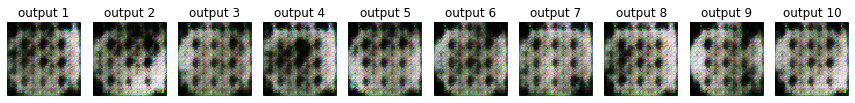

Iter:550, LossG (fake:0.7731), LossD:1.0771 (real:0.4245, fake:0.6526)
Iter:600, LossG (fake:0.9201), LossD:1.0604 (real:0.5201, fake:0.5403)
save G >> models/DCGAN_G_iter600.pt, D >> models/DCGAN_D_iter600.pt
Iter:650, LossG (fake:0.9105), LossD:1.1834 (real:0.6334, fake:0.5500)
Iter:700, LossG (fake:0.8584), LossD:0.9797 (real:0.3907, fake:0.5890)
Iter:750, LossG (fake:1.1938), LossD:1.1677 (real:0.7611, fake:0.4066)
Iter:800, LossG (fake:1.6794), LossD:1.2657 (real:1.0342, fake:0.2315)
save G >> models/DCGAN_G_iter800.pt, D >> models/DCGAN_D_iter800.pt
Iter:850, LossG (fake:0.7522), LossD:1.2920 (real:0.6331, fake:0.6590)
Iter:900, LossG (fake:0.8698), LossD:1.2616 (real:0.6678, fake:0.5939)
Iter:950, LossG (fake:0.7368), LossD:1.1633 (real:0.4804, fake:0.6828)
Iter:1000, LossG (fake:0.6109), LossD:1.2368 (real:0.4268, fake:0.8100)
save G >> models/DCGAN_G_iter1000.pt, D >> models/DCGAN_D_iter1000.pt
result was saved to >> result/DCGAN_result_iter1000.jpg


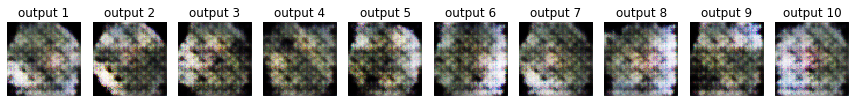

Iter:1050, LossG (fake:0.6773), LossD:1.1952 (real:0.4640, fake:0.7313)
Iter:1100, LossG (fake:0.7825), LossD:1.1834 (real:0.5302, fake:0.6531)
Iter:1150, LossG (fake:0.9068), LossD:1.4253 (real:0.8721, fake:0.5532)
Iter:1200, LossG (fake:1.1678), LossD:1.1156 (real:0.7076, fake:0.4080)
save G >> models/DCGAN_G_iter1200.pt, D >> models/DCGAN_D_iter1200.pt
Iter:1250, LossG (fake:0.8150), LossD:1.1512 (real:0.5300, fake:0.6213)
Iter:1300, LossG (fake:0.7933), LossD:1.1158 (real:0.4517, fake:0.6641)
Iter:1350, LossG (fake:1.0911), LossD:1.2269 (real:0.7926, fake:0.4343)
Iter:1400, LossG (fake:0.8753), LossD:1.0813 (real:0.5081, fake:0.5732)
save G >> models/DCGAN_G_iter1400.pt, D >> models/DCGAN_D_iter1400.pt
Iter:1450, LossG (fake:1.0043), LossD:1.1170 (real:0.6062, fake:0.5107)
Iter:1500, LossG (fake:0.8563), LossD:1.3056 (real:0.6662, fake:0.6393)
result was saved to >> result/DCGAN_result_iter1500.jpg


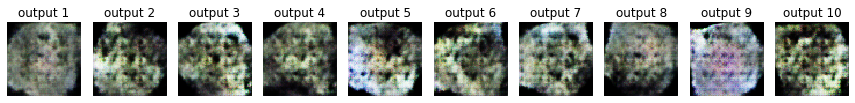

Iter:1550, LossG (fake:0.9536), LossD:1.2651 (real:0.6854, fake:0.5798)
Iter:1600, LossG (fake:1.0253), LossD:0.9984 (real:0.4784, fake:0.5200)
save G >> models/DCGAN_G_iter1600.pt, D >> models/DCGAN_D_iter1600.pt
Iter:1650, LossG (fake:0.8489), LossD:1.0562 (real:0.4136, fake:0.6425)
Iter:1700, LossG (fake:0.7977), LossD:1.2540 (real:0.4902, fake:0.7638)
Iter:1750, LossG (fake:1.0382), LossD:0.9377 (real:0.4222, fake:0.5154)
Iter:1800, LossG (fake:0.6524), LossD:1.1789 (real:0.2912, fake:0.8877)
save G >> models/DCGAN_G_iter1800.pt, D >> models/DCGAN_D_iter1800.pt
Iter:1850, LossG (fake:1.3936), LossD:0.8673 (real:0.5099, fake:0.3574)
Iter:1900, LossG (fake:0.9950), LossD:1.0996 (real:0.5285, fake:0.5711)
Iter:1950, LossG (fake:1.0227), LossD:0.8569 (real:0.2595, fake:0.5973)
Iter:2000, LossG (fake:1.3460), LossD:0.8715 (real:0.3675, fake:0.5040)
save G >> models/DCGAN_G_iter2000.pt, D >> models/DCGAN_D_iter2000.pt
result was saved to >> result/DCGAN_result_iter2000.jpg


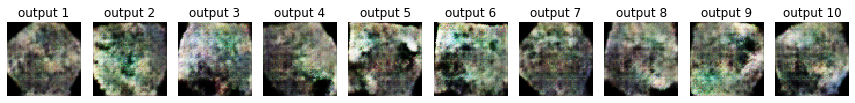

Iter:2050, LossG (fake:1.6245), LossD:0.5763 (real:0.2928, fake:0.2834)
Iter:2100, LossG (fake:2.2455), LossD:1.0030 (real:0.8424, fake:0.1606)
Iter:2150, LossG (fake:1.3189), LossD:0.6733 (real:0.2518, fake:0.4216)
Iter:2200, LossG (fake:1.5066), LossD:0.5078 (real:0.1451, fake:0.3628)
save G >> models/DCGAN_G_iter2200.pt, D >> models/DCGAN_D_iter2200.pt
Iter:2250, LossG (fake:2.1615), LossD:0.7281 (real:0.4509, fake:0.2773)
Iter:2300, LossG (fake:2.0908), LossD:0.5985 (real:0.3364, fake:0.2621)
Iter:2350, LossG (fake:2.1183), LossD:0.5586 (real:0.3500, fake:0.2086)
Iter:2400, LossG (fake:2.7729), LossD:0.5457 (real:0.3610, fake:0.1847)
save G >> models/DCGAN_G_iter2400.pt, D >> models/DCGAN_D_iter2400.pt
Iter:2450, LossG (fake:2.4507), LossD:0.7424 (real:0.2819, fake:0.4604)
Iter:2500, LossG (fake:3.0021), LossD:0.2870 (real:0.1860, fake:0.1011)
result was saved to >> result/DCGAN_result_iter2500.jpg


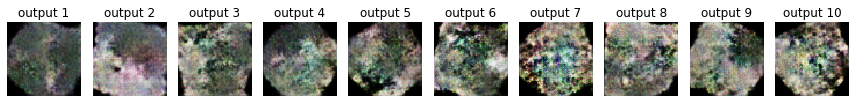

Iter:2550, LossG (fake:1.8717), LossD:0.3048 (real:0.0392, fake:0.2656)
Iter:2600, LossG (fake:3.0198), LossD:0.4120 (real:0.3014, fake:0.1106)
save G >> models/DCGAN_G_iter2600.pt, D >> models/DCGAN_D_iter2600.pt
Iter:2650, LossG (fake:3.4587), LossD:0.1472 (real:0.0582, fake:0.0890)
Iter:2700, LossG (fake:2.7582), LossD:0.1955 (real:0.0867, fake:0.1087)
Iter:2750, LossG (fake:3.1080), LossD:0.2771 (real:0.0537, fake:0.2234)
Iter:2800, LossG (fake:2.9885), LossD:0.1811 (real:0.0128, fake:0.1683)
save G >> models/DCGAN_G_iter2800.pt, D >> models/DCGAN_D_iter2800.pt
Iter:2850, LossG (fake:2.3929), LossD:0.2174 (real:0.0190, fake:0.1984)
Iter:2900, LossG (fake:4.5234), LossD:0.6674 (real:0.6047, fake:0.0627)
Iter:2950, LossG (fake:3.7466), LossD:0.1499 (real:0.0487, fake:0.1011)
Iter:3000, LossG (fake:4.9996), LossD:0.3694 (real:0.2374, fake:0.1319)
save G >> models/DCGAN_G_iter3000.pt, D >> models/DCGAN_D_iter3000.pt
result was saved to >> result/DCGAN_result_iter3000.jpg


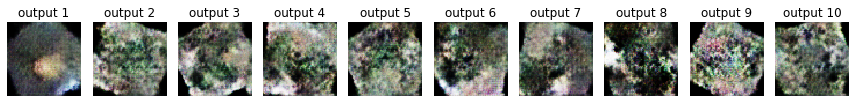

Iter:3050, LossG (fake:5.2918), LossD:0.1766 (real:0.1405, fake:0.0361)
Iter:3100, LossG (fake:4.1836), LossD:0.0729 (real:0.0321, fake:0.0408)
Iter:3150, LossG (fake:5.5443), LossD:0.2770 (real:0.1186, fake:0.1584)
Iter:3200, LossG (fake:4.3121), LossD:0.0604 (real:0.0160, fake:0.0443)
save G >> models/DCGAN_G_iter3200.pt, D >> models/DCGAN_D_iter3200.pt
Iter:3250, LossG (fake:6.7023), LossD:0.3181 (real:0.3127, fake:0.0054)
Iter:3300, LossG (fake:5.8519), LossD:0.1843 (real:0.1264, fake:0.0579)
Iter:3350, LossG (fake:5.1031), LossD:0.1092 (real:0.0459, fake:0.0634)
Iter:3400, LossG (fake:4.9173), LossD:0.1001 (real:0.0494, fake:0.0508)
save G >> models/DCGAN_G_iter3400.pt, D >> models/DCGAN_D_iter3400.pt
Iter:3450, LossG (fake:4.1482), LossD:0.1541 (real:0.0169, fake:0.1372)
Iter:3500, LossG (fake:4.1016), LossD:0.2229 (real:0.0408, fake:0.1821)
result was saved to >> result/DCGAN_result_iter3500.jpg


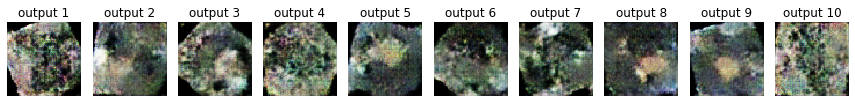

Iter:3550, LossG (fake:5.1851), LossD:0.0257 (real:0.0048, fake:0.0209)
Iter:3600, LossG (fake:5.8758), LossD:0.0909 (real:0.0688, fake:0.0221)
save G >> models/DCGAN_G_iter3600.pt, D >> models/DCGAN_D_iter3600.pt
Iter:3650, LossG (fake:7.1915), LossD:0.2407 (real:0.1889, fake:0.0518)
Iter:3700, LossG (fake:4.4442), LossD:0.1060 (real:0.0252, fake:0.0807)
Iter:3750, LossG (fake:4.6483), LossD:0.0910 (real:0.0094, fake:0.0816)
Iter:3800, LossG (fake:4.9862), LossD:0.0913 (real:0.0450, fake:0.0463)
save G >> models/DCGAN_G_iter3800.pt, D >> models/DCGAN_D_iter3800.pt
Iter:3850, LossG (fake:6.1730), LossD:0.0490 (real:0.0317, fake:0.0173)
Iter:3900, LossG (fake:6.0613), LossD:0.0675 (real:0.0399, fake:0.0276)
Iter:3950, LossG (fake:6.4593), LossD:0.0339 (real:0.0115, fake:0.0224)
Iter:4000, LossG (fake:5.4230), LossD:0.0683 (real:0.0063, fake:0.0620)
save G >> models/DCGAN_G_iter4000.pt, D >> models/DCGAN_D_iter4000.pt
result was saved to >> result/DCGAN_result_iter4000.jpg


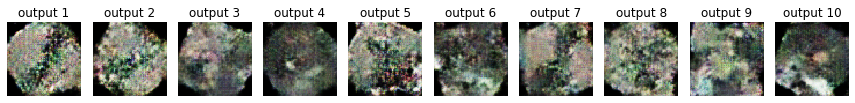

Iter:4050, LossG (fake:6.1874), LossD:0.0198 (real:0.0056, fake:0.0142)
Iter:4100, LossG (fake:5.7998), LossD:0.0818 (real:0.0144, fake:0.0674)
Iter:4150, LossG (fake:5.7140), LossD:0.0516 (real:0.0058, fake:0.0458)
Iter:4200, LossG (fake:3.9612), LossD:0.2318 (real:0.0118, fake:0.2200)
save G >> models/DCGAN_G_iter4200.pt, D >> models/DCGAN_D_iter4200.pt
Iter:4250, LossG (fake:7.0498), LossD:0.0112 (real:0.0067, fake:0.0045)
Iter:4300, LossG (fake:4.8222), LossD:0.0485 (real:0.0085, fake:0.0400)
Iter:4350, LossG (fake:7.5989), LossD:0.1013 (real:0.0270, fake:0.0743)
Iter:4400, LossG (fake:8.1187), LossD:0.0261 (real:0.0099, fake:0.0162)
save G >> models/DCGAN_G_iter4400.pt, D >> models/DCGAN_D_iter4400.pt
Iter:4450, LossG (fake:6.1330), LossD:0.0261 (real:0.0009, fake:0.0252)
Iter:4500, LossG (fake:7.0234), LossD:0.0291 (real:0.0180, fake:0.0111)
result was saved to >> result/DCGAN_result_iter4500.jpg


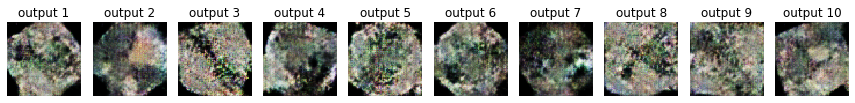

Iter:4550, LossG (fake:5.2690), LossD:0.0733 (real:0.0023, fake:0.0710)
Iter:4600, LossG (fake:5.2948), LossD:0.0497 (real:0.0002, fake:0.0495)
save G >> models/DCGAN_G_iter4600.pt, D >> models/DCGAN_D_iter4600.pt
Iter:4650, LossG (fake:6.5300), LossD:0.0808 (real:0.0542, fake:0.0266)
Iter:4700, LossG (fake:7.7183), LossD:0.0279 (real:0.0077, fake:0.0201)
Iter:4750, LossG (fake:8.3054), LossD:0.0338 (real:0.0299, fake:0.0040)
Iter:4800, LossG (fake:6.1694), LossD:0.1793 (real:0.0215, fake:0.1578)
save G >> models/DCGAN_G_iter4800.pt, D >> models/DCGAN_D_iter4800.pt
Iter:4850, LossG (fake:8.6206), LossD:0.0628 (real:0.0535, fake:0.0093)
Iter:4900, LossG (fake:7.9974), LossD:0.0332 (real:0.0315, fake:0.0017)
Iter:4950, LossG (fake:8.3819), LossD:0.0042 (real:0.0029, fake:0.0013)
Iter:5000, LossG (fake:8.0714), LossD:0.1314 (real:0.1264, fake:0.0049)
save G >> models/DCGAN_G_iter5000.pt, D >> models/DCGAN_D_iter5000.pt
result was saved to >> result/DCGAN_result_iter5000.jpg


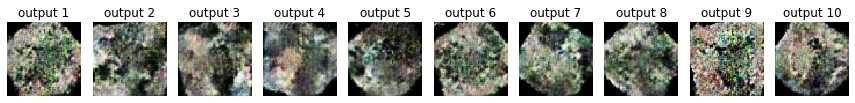

Iter:5050, LossG (fake:9.0301), LossD:0.1654 (real:0.0911, fake:0.0743)
Iter:5100, LossG (fake:8.4726), LossD:0.0182 (real:0.0147, fake:0.0035)
Iter:5150, LossG (fake:7.3786), LossD:0.0369 (real:0.0097, fake:0.0272)
Iter:5200, LossG (fake:9.7698), LossD:0.0497 (real:0.0478, fake:0.0019)
save G >> models/DCGAN_G_iter5200.pt, D >> models/DCGAN_D_iter5200.pt
Iter:5250, LossG (fake:8.7338), LossD:0.0745 (real:0.0212, fake:0.0533)
Iter:5300, LossG (fake:8.4386), LossD:0.0092 (real:0.0062, fake:0.0030)
Iter:5350, LossG (fake:7.0245), LossD:0.0244 (real:0.0017, fake:0.0227)
Iter:5400, LossG (fake:8.4840), LossD:0.0032 (real:0.0018, fake:0.0015)
save G >> models/DCGAN_G_iter5400.pt, D >> models/DCGAN_D_iter5400.pt
Iter:5450, LossG (fake:8.0142), LossD:0.0075 (real:0.0040, fake:0.0034)
Iter:5500, LossG (fake:7.6116), LossD:0.0407 (real:0.0101, fake:0.0306)
result was saved to >> result/DCGAN_result_iter5500.jpg


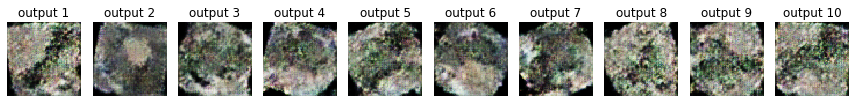

Iter:5550, LossG (fake:9.1975), LossD:0.0306 (real:0.0143, fake:0.0163)
Iter:5600, LossG (fake:7.1481), LossD:0.0690 (real:0.0003, fake:0.0687)
save G >> models/DCGAN_G_iter5600.pt, D >> models/DCGAN_D_iter5600.pt
Iter:5650, LossG (fake:10.5213), LossD:0.0316 (real:0.0199, fake:0.0117)
Iter:5700, LossG (fake:6.3067), LossD:0.0382 (real:0.0021, fake:0.0361)
Iter:5750, LossG (fake:8.6997), LossD:0.0527 (real:0.0499, fake:0.0028)
Iter:5800, LossG (fake:6.8671), LossD:0.0330 (real:0.0004, fake:0.0326)
save G >> models/DCGAN_G_iter5800.pt, D >> models/DCGAN_D_iter5800.pt
Iter:5850, LossG (fake:8.4378), LossD:0.0174 (real:0.0020, fake:0.0155)
Iter:5900, LossG (fake:7.8468), LossD:0.1244 (real:0.0155, fake:0.1089)
Iter:5950, LossG (fake:11.2966), LossD:0.2272 (real:0.2258, fake:0.0014)
Iter:6000, LossG (fake:12.1175), LossD:0.0024 (real:0.0014, fake:0.0011)
save G >> models/DCGAN_G_iter6000.pt, D >> models/DCGAN_D_iter6000.pt
result was saved to >> result/DCGAN_result_iter6000.jpg


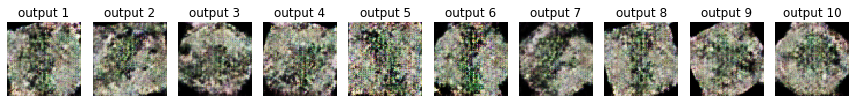

Iter:6050, LossG (fake:10.4512), LossD:0.0080 (real:0.0076, fake:0.0004)
Iter:6100, LossG (fake:8.1605), LossD:0.0346 (real:0.0113, fake:0.0233)
Iter:6150, LossG (fake:7.8083), LossD:0.1036 (real:0.0021, fake:0.1015)
Iter:6200, LossG (fake:12.2001), LossD:0.1445 (real:0.1428, fake:0.0017)
save G >> models/DCGAN_G_iter6200.pt, D >> models/DCGAN_D_iter6200.pt
Iter:6250, LossG (fake:10.6402), LossD:0.0013 (real:0.0008, fake:0.0005)
Iter:6300, LossG (fake:9.1463), LossD:0.1613 (real:0.1144, fake:0.0470)
Iter:6350, LossG (fake:7.5277), LossD:0.1237 (real:0.0048, fake:0.1189)
Iter:6400, LossG (fake:9.3953), LossD:0.0101 (real:0.0037, fake:0.0064)
save G >> models/DCGAN_G_iter6400.pt, D >> models/DCGAN_D_iter6400.pt
Iter:6450, LossG (fake:7.0629), LossD:0.0221 (real:0.0019, fake:0.0202)
Iter:6500, LossG (fake:7.8725), LossD:0.0058 (real:0.0037, fake:0.0021)
result was saved to >> result/DCGAN_result_iter6500.jpg


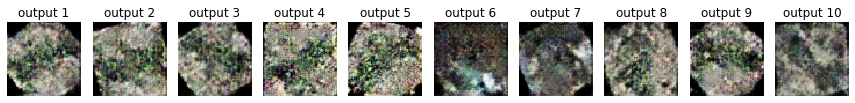

Iter:6550, LossG (fake:7.2926), LossD:0.0743 (real:0.0009, fake:0.0734)
Iter:6600, LossG (fake:10.0131), LossD:0.1398 (real:0.1355, fake:0.0043)
save G >> models/DCGAN_G_iter6600.pt, D >> models/DCGAN_D_iter6600.pt
Iter:6650, LossG (fake:10.0442), LossD:0.0130 (real:0.0121, fake:0.0009)
Iter:6700, LossG (fake:6.5679), LossD:0.0533 (real:0.0000, fake:0.0533)
Iter:6750, LossG (fake:11.4776), LossD:0.0565 (real:0.0562, fake:0.0004)
Iter:6800, LossG (fake:8.1025), LossD:0.0280 (real:0.0002, fake:0.0278)
save G >> models/DCGAN_G_iter6800.pt, D >> models/DCGAN_D_iter6800.pt
Iter:6850, LossG (fake:6.3047), LossD:0.1262 (real:0.0039, fake:0.1223)
Iter:6900, LossG (fake:8.0367), LossD:0.1710 (real:0.0397, fake:0.1313)
Iter:6950, LossG (fake:11.2497), LossD:0.0038 (real:0.0008, fake:0.0029)
Iter:7000, LossG (fake:9.7280), LossD:0.0780 (real:0.0454, fake:0.0326)
save G >> models/DCGAN_G_iter7000.pt, D >> models/DCGAN_D_iter7000.pt
result was saved to >> result/DCGAN_result_iter7000.jpg


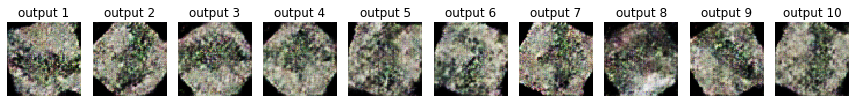

Iter:7050, LossG (fake:10.5093), LossD:0.0067 (real:0.0009, fake:0.0058)
Iter:7100, LossG (fake:8.5547), LossD:0.0568 (real:0.0276, fake:0.0291)
Iter:7150, LossG (fake:8.8428), LossD:0.0870 (real:0.0190, fake:0.0680)
Iter:7200, LossG (fake:8.4534), LossD:0.0059 (real:0.0029, fake:0.0030)
save G >> models/DCGAN_G_iter7200.pt, D >> models/DCGAN_D_iter7200.pt
Iter:7250, LossG (fake:8.1901), LossD:0.0314 (real:0.0008, fake:0.0305)
Iter:7300, LossG (fake:9.4767), LossD:0.0358 (real:0.0350, fake:0.0008)
Iter:7350, LossG (fake:11.9704), LossD:0.0222 (real:0.0093, fake:0.0129)
Iter:7400, LossG (fake:8.9374), LossD:0.0098 (real:0.0029, fake:0.0069)
save G >> models/DCGAN_G_iter7400.pt, D >> models/DCGAN_D_iter7400.pt
Iter:7450, LossG (fake:8.2901), LossD:0.0105 (real:0.0060, fake:0.0045)
Iter:7500, LossG (fake:10.8087), LossD:0.0035 (real:0.0016, fake:0.0019)
result was saved to >> result/DCGAN_result_iter7500.jpg


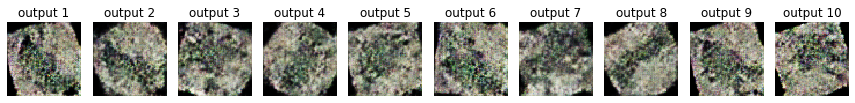

Iter:7550, LossG (fake:10.1293), LossD:0.1425 (real:0.0075, fake:0.1351)
Iter:7600, LossG (fake:10.5684), LossD:0.0461 (real:0.0409, fake:0.0052)
save G >> models/DCGAN_G_iter7600.pt, D >> models/DCGAN_D_iter7600.pt
Iter:7650, LossG (fake:10.0229), LossD:0.0875 (real:0.0808, fake:0.0066)
Iter:7700, LossG (fake:10.4288), LossD:0.0458 (real:0.0450, fake:0.0008)
Iter:7750, LossG (fake:11.8916), LossD:0.0249 (real:0.0248, fake:0.0001)
Iter:7800, LossG (fake:8.6429), LossD:0.0231 (real:0.0180, fake:0.0050)
save G >> models/DCGAN_G_iter7800.pt, D >> models/DCGAN_D_iter7800.pt
Iter:7850, LossG (fake:8.4137), LossD:0.0406 (real:0.0195, fake:0.0211)
Iter:7900, LossG (fake:8.3209), LossD:0.0073 (real:0.0007, fake:0.0066)
Iter:7950, LossG (fake:9.0528), LossD:0.0045 (real:0.0003, fake:0.0042)
Iter:8000, LossG (fake:6.9435), LossD:0.1523 (real:0.0302, fake:0.1220)
save G >> models/DCGAN_G_iter8000.pt, D >> models/DCGAN_D_iter8000.pt
result was saved to >> result/DCGAN_result_iter8000.jpg


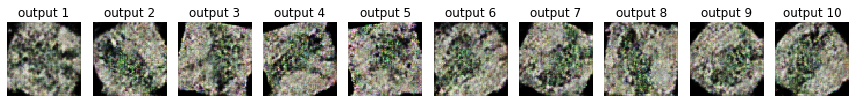

Iter:8050, LossG (fake:9.7061), LossD:0.0128 (real:0.0115, fake:0.0014)
Iter:8100, LossG (fake:12.8162), LossD:0.1225 (real:0.1221, fake:0.0003)
Iter:8150, LossG (fake:9.5792), LossD:0.2619 (real:0.2578, fake:0.0041)
Iter:8200, LossG (fake:8.2363), LossD:0.0533 (real:0.0016, fake:0.0517)
save G >> models/DCGAN_G_iter8200.pt, D >> models/DCGAN_D_iter8200.pt
Iter:8250, LossG (fake:5.4540), LossD:0.3690 (real:0.0229, fake:0.3462)
Iter:8300, LossG (fake:8.1441), LossD:0.0744 (real:0.0072, fake:0.0672)
Iter:8350, LossG (fake:8.7264), LossD:0.0205 (real:0.0171, fake:0.0034)
Iter:8400, LossG (fake:7.6868), LossD:0.0426 (real:0.0228, fake:0.0198)
save G >> models/DCGAN_G_iter8400.pt, D >> models/DCGAN_D_iter8400.pt
Iter:8450, LossG (fake:7.1045), LossD:0.0964 (real:0.0129, fake:0.0835)
Iter:8500, LossG (fake:4.7329), LossD:0.1936 (real:0.0001, fake:0.1935)
result was saved to >> result/DCGAN_result_iter8500.jpg


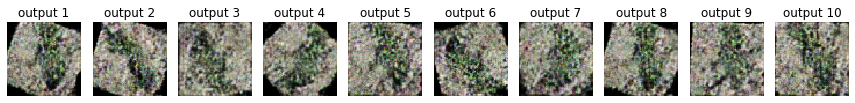

Iter:8550, LossG (fake:11.3723), LossD:0.1208 (real:0.1202, fake:0.0006)
Iter:8600, LossG (fake:7.7814), LossD:0.0508 (real:0.0142, fake:0.0366)
save G >> models/DCGAN_G_iter8600.pt, D >> models/DCGAN_D_iter8600.pt
Iter:8650, LossG (fake:8.6314), LossD:0.0099 (real:0.0027, fake:0.0072)
Iter:8700, LossG (fake:10.2057), LossD:0.0687 (real:0.0682, fake:0.0005)
Iter:8750, LossG (fake:9.3966), LossD:0.0385 (real:0.0336, fake:0.0048)
Iter:8800, LossG (fake:8.7641), LossD:0.0090 (real:0.0005, fake:0.0084)
save G >> models/DCGAN_G_iter8800.pt, D >> models/DCGAN_D_iter8800.pt
Iter:8850, LossG (fake:10.6080), LossD:0.4873 (real:0.4827, fake:0.0046)
Iter:8900, LossG (fake:6.4565), LossD:0.1974 (real:0.0016, fake:0.1958)
Iter:8950, LossG (fake:10.7121), LossD:0.0762 (real:0.0573, fake:0.0190)
Iter:9000, LossG (fake:9.6398), LossD:0.0781 (real:0.0050, fake:0.0731)
save G >> models/DCGAN_G_iter9000.pt, D >> models/DCGAN_D_iter9000.pt
result was saved to >> result/DCGAN_result_iter9000.jpg


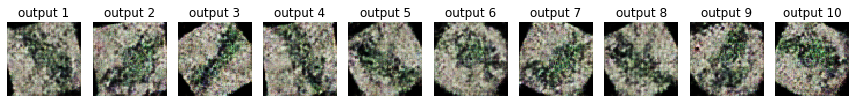

Iter:9050, LossG (fake:6.4043), LossD:0.0641 (real:0.0007, fake:0.0634)
Iter:9100, LossG (fake:6.8469), LossD:0.0775 (real:0.0032, fake:0.0743)
Iter:9150, LossG (fake:6.8889), LossD:0.1015 (real:0.0124, fake:0.0891)
Iter:9200, LossG (fake:6.5821), LossD:0.1118 (real:0.0039, fake:0.1079)
save G >> models/DCGAN_G_iter9200.pt, D >> models/DCGAN_D_iter9200.pt
Iter:9250, LossG (fake:6.7427), LossD:0.0320 (real:0.0108, fake:0.0212)
Iter:9300, LossG (fake:7.9325), LossD:0.0340 (real:0.0280, fake:0.0060)
Iter:9350, LossG (fake:10.3872), LossD:0.0077 (real:0.0066, fake:0.0011)
Iter:9400, LossG (fake:7.9732), LossD:0.0325 (real:0.0001, fake:0.0324)
save G >> models/DCGAN_G_iter9400.pt, D >> models/DCGAN_D_iter9400.pt
Iter:9450, LossG (fake:7.4570), LossD:0.0573 (real:0.0001, fake:0.0572)
Iter:9500, LossG (fake:7.0474), LossD:0.0567 (real:0.0280, fake:0.0287)
result was saved to >> result/DCGAN_result_iter9500.jpg


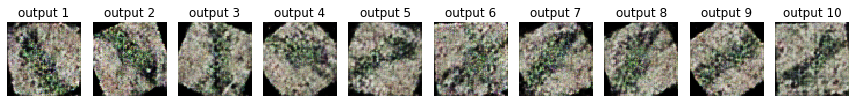

Iter:9550, LossG (fake:7.6086), LossD:0.0497 (real:0.0224, fake:0.0273)
Iter:9600, LossG (fake:5.1344), LossD:0.0419 (real:0.0002, fake:0.0417)
save G >> models/DCGAN_G_iter9600.pt, D >> models/DCGAN_D_iter9600.pt
Iter:9650, LossG (fake:5.7750), LossD:0.1918 (real:0.0498, fake:0.1420)
Iter:9700, LossG (fake:6.9944), LossD:0.0157 (real:0.0001, fake:0.0156)
Iter:9750, LossG (fake:6.9740), LossD:0.0335 (real:0.0023, fake:0.0312)
Iter:9800, LossG (fake:9.1559), LossD:0.0173 (real:0.0151, fake:0.0022)
save G >> models/DCGAN_G_iter9800.pt, D >> models/DCGAN_D_iter9800.pt
Iter:9850, LossG (fake:7.9349), LossD:0.0203 (real:0.0035, fake:0.0169)
Iter:9900, LossG (fake:8.5209), LossD:0.0704 (real:0.0630, fake:0.0075)
Iter:9950, LossG (fake:7.3869), LossD:0.0808 (real:0.0518, fake:0.0290)
Iter:10000, LossG (fake:7.8568), LossD:0.3484 (real:0.2920, fake:0.0564)
save G >> models/DCGAN_G_iter10000.pt, D >> models/DCGAN_D_iter10000.pt
result was saved to >> result/DCGAN_result_iter10000.jpg


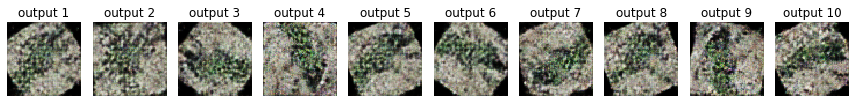

final paramters were saved to G >> models/DCGAN_G_final.pt, D >> models/DCGAN_D_final.pt
loss was saved to >> result/DCGAN_loss.txt


In [0]:
def train():
    # model
    G = Generator().to(cfg.DEVICE)
    D = Discriminator().to(cfg.DEVICE)
    
    summary(G, (cfg.INPUT_Z_DIM, 1, 1))
    summary(D, (cfg.OUTPUT_CHANNEL, cfg.OUTPUT_HEIGHT, cfg.OUTPUT_WIDTH))

    opt_G = cfg.TRAIN.OPTIMIZER_G(G.parameters(), **cfg.TRAIN.LEARNING_PARAMS_G)
    opt_D = cfg.TRAIN.OPTIMIZER_D(D.parameters(), **cfg.TRAIN.LEARNING_PARAMS_D)

    path_dict = data_load(cfg, hf=cfg.TRAIN.DATA_HORIZONTAL_FLIP, vf=cfg.TRAIN.DATA_VERTICAL_FLIP, rot=cfg.TRAIN.DATA_ROTATION)
    paths = path_dict['paths']
    paths_gt = path_dict['paths_gt']

    # training
    mbi = 0
    train_N = len(paths)
    train_ind = np.arange(train_N)
    np.random.seed(0)
    np.random.shuffle(train_ind)

    list_iter = []
    list_loss_G = []
    list_loss_D = []
    list_loss_D_real = []
    list_loss_D_fake = []

    print('training start')
    progres_bar = ''

    if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE:
        f = open(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH, 'w')
        f.write('iteration,loss_G,loss_G_fake,loss_D,loss_D_real,loss_D_fake\n')
    
    for i in range(cfg.TRAIN.ITERATION):
        if mbi + cfg.TRAIN.MINIBATCH > train_N:
            mb_ind = train_ind[mbi:]
            np.random.shuffle(train_ind)
            mb_ind = np.hstack((mb_ind, train_ind[ : (cfg.TRAIN.MINIBATCH - (train_N - mbi))]))
            mbi = cfg.TRAIN.MINIBATCH - (train_N - mbi)
        else:
            mb_ind = train_ind[mbi : mbi + cfg.TRAIN.MINIBATCH]
            mbi += cfg.TRAIN.MINIBATCH

        opt_D.zero_grad()

        # sample X
        Xs = torch.tensor(get_image(paths[mb_ind], cfg, cfg.INPUT_MODE), dtype=torch.float).to(cfg.DEVICE)

        # sample x
        z = np.random.uniform(-1, 1, size=(cfg.TRAIN.MINIBATCH, cfg.INPUT_Z_DIM, 1, 1))
        z = torch.tensor(z, dtype=torch.float).to(cfg.DEVICE)

        # forward
        Gz = G(z)
        D_real = D(Xs)[..., 0, 0, 0]
        D_fake = D(Gz)[..., 0, 0, 0]

        # update D
        loss_D_real = cfg.TRAIN.LOSS_FUNCTION(D_real, torch.ones(cfg.TRAIN.MINIBATCH).to(cfg.DEVICE))
        loss_D_fake = cfg.TRAIN.LOSS_FUNCTION(D_fake, torch.zeros(cfg.TRAIN.MINIBATCH).to(cfg.DEVICE))
        loss_D = loss_D_real + loss_D_fake
        loss_D.backward(retain_graph=True)
        opt_D.step()

        # update G
        opt_G.zero_grad()
        loss_G = cfg.TRAIN.LOSS_FUNCTION(D_fake, torch.ones(cfg.TRAIN.MINIBATCH).to(cfg.DEVICE))
        loss_G.backward()
        opt_G.step()


        progres_bar += '|'
        print('\r' + progres_bar, end='')

        _loss_G = loss_G.item()
        _loss_D = loss_D.item()
        _loss_D_real = loss_D_real.item()
        _loss_D_fake = loss_D_fake.item()

        if (i + 1) % 10 == 0:
            progres_bar += str(i + 1)
            print('\r' + progres_bar, end='')

            # save process result
            if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE:
                list_iter.append(i + 1)
                list_loss_G.append(_loss_G)
                list_loss_D.append(_loss_D)
                list_loss_D_real.append(_loss_D_real)
                list_loss_D_fake.append(_loss_D_fake)

        # display training state
        if (i + 1) % cfg.TRAIN.DISPAY_ITERATION_INTERVAL == 0:
            print('\r' + ' ' * len(progres_bar), end='')
            print('\rIter:{}, LossG (fake:{:.4f}), LossD:{:.4f} (real:{:.4f}, fake:{:.4f})'.format(
                i + 1, _loss_G, _loss_D, _loss_D_real, _loss_D_fake))
            progres_bar = ''

        # save parameters
        if (cfg.TRAIN.MODEL_SAVE_INTERVAL != False) and ((i + 1) % cfg.TRAIN.MODEL_SAVE_INTERVAL == 0):
            G_save_path = cfg.TRAIN.MODEL_G_SAVE_PATH.format('iter{}'.format(i + 1))
            D_save_path = cfg.TRAIN.MODEL_D_SAVE_PATH.format('iter{}'.format(i + 1))
            torch.save(G.state_dict(), G_save_path)
            torch.save(D.state_dict(), D_save_path)
            print('save G >> {}, D >> {}'.format(G_save_path, D_save_path))

        # save process result
        if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE and ((i + 1) % cfg.TRAIN.LEARNING_PROCESS_RESULT_INTERVAL == 0):
            result_show(
                G, z, cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH.format('iter' + str(i + 1)), 
                save=cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE, show=True, cmap_in=cfg.INPUT_CMAP, cmap_out=cfg.OUTPUT_CMAP)

    G_save_path = cfg.TRAIN.MODEL_G_SAVE_PATH.format('final')
    D_save_path = cfg.TRAIN.MODEL_D_SAVE_PATH.format('final')
    torch.save(G.state_dict(), G_save_path)
    torch.save(D.state_dict(), D_save_path)
    print('final paramters were saved to G >> {}, D >> {}'.format(G_save_path, D_save_path))

    if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE:
        f = open(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH, 'w')
        df = pd.DataFrame({'iteration' : list_iter, 'loss_G' : list_loss_G, 'loss_D' : list_loss_D, 'loss_D_real' : list_loss_D_real, 'loss_D_fake' : list_loss_D_fake})
        df.to_csv(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH, index=False)
        print('loss was saved to >> {}'.format(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH))
        
train()

## Test

--------------------
test function
--------------------


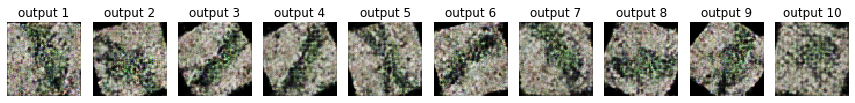

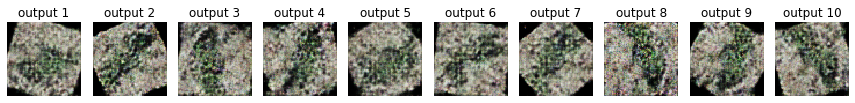

In [0]:
# test
def test():
    print('-' * 20)
    print('test function')
    print('-' * 20)
    G = Generator().to(cfg.DEVICE)
    G.load_state_dict(torch.load(cfg.TEST.MODEL_G_PATH, map_location=torch.device(cfg.DEVICE)))
    G.eval()

    np.random.seed(0)
    
    for i in range(cfg.TEST.ITERATION):
        z = np.random.uniform(-1, 1, size=(cfg.TEST.MINIBATCH, cfg.INPUT_Z_DIM, 1, 1))
        z = torch.tensor(z, dtype=torch.float).to(cfg.DEVICE)

        result_show(G, z, cfg.TEST.RESULT_IMAGE_PATH.format(i + 1), save=cfg.TEST.RESULT_SAVE, show=True)

test()

In [0]:
def arg_parse():
    parser = argparse.ArgumentParser(description='CNN implemented with Keras')
    parser.add_argument('--train', dest='train', action='store_true')
    parser.add_argument('--test', dest='test', action='store_true')
    args = parser.parse_args()
    return args

# main
"""
if __name__ == '__main__':
    args = arg_parse()

    if args.train:
        train()
    if args.test:
        test()

    if not (args.train or args.test):
        print("please select train or test flag")
        print("train: python main.py --train")
        print("test:  python main.py --test")
        print("both:  python main.py --train --test")
"""